# Project 3 - Regression and Classification with the Ames Housing Data

## Part 2

---
Reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

**Goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns',None)

sns.set_style('white')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# h2 : updated house data
house = pd.read_csv('h2.csv')

del house['Unnamed: 0']
house.columns

Index([u'id', u'mssubclass', u'mszoning', u'lotfrontage', u'lotarea',
       u'street', u'lotshape', u'landcontour', u'utilities', u'lotconfig',
       u'landslope', u'neighborhood', u'condition1', u'condition2',
       u'bldgtype', u'housestyle', u'overallqual', u'overallcond',
       u'yearbuilt', u'yearremodadd', u'roofstyle', u'roofmatl',
       u'exterior1st', u'exterior2nd', u'exterqual', u'extercond',
       u'foundation', u'bsmtqual', u'bsmtcond', u'bsmtexposure',
       u'bsmtfintype1', u'bsmtfinsf1', u'bsmtfintype2', u'bsmtfinsf2',
       u'bsmtunfsf', u'totalbsmtsf', u'heating', u'heatingqc', u'centralair',
       u'electrical', u'1stflrsf', u'2ndflrsf', u'lowqualfinsf', u'grlivarea',
       u'bsmtfullbath', u'bsmthalfbath', u'fullbath', u'halfbath',
       u'bedroomabvgr', u'kitchenabvgr', u'kitchenqual', u'totrmsabvgrd',
       u'functional', u'fireplaces', u'fireplacequ', u'garagetype',
       u'garagefinish', u'garagecars', u'garagearea', u'garagequal',
       u'garageco

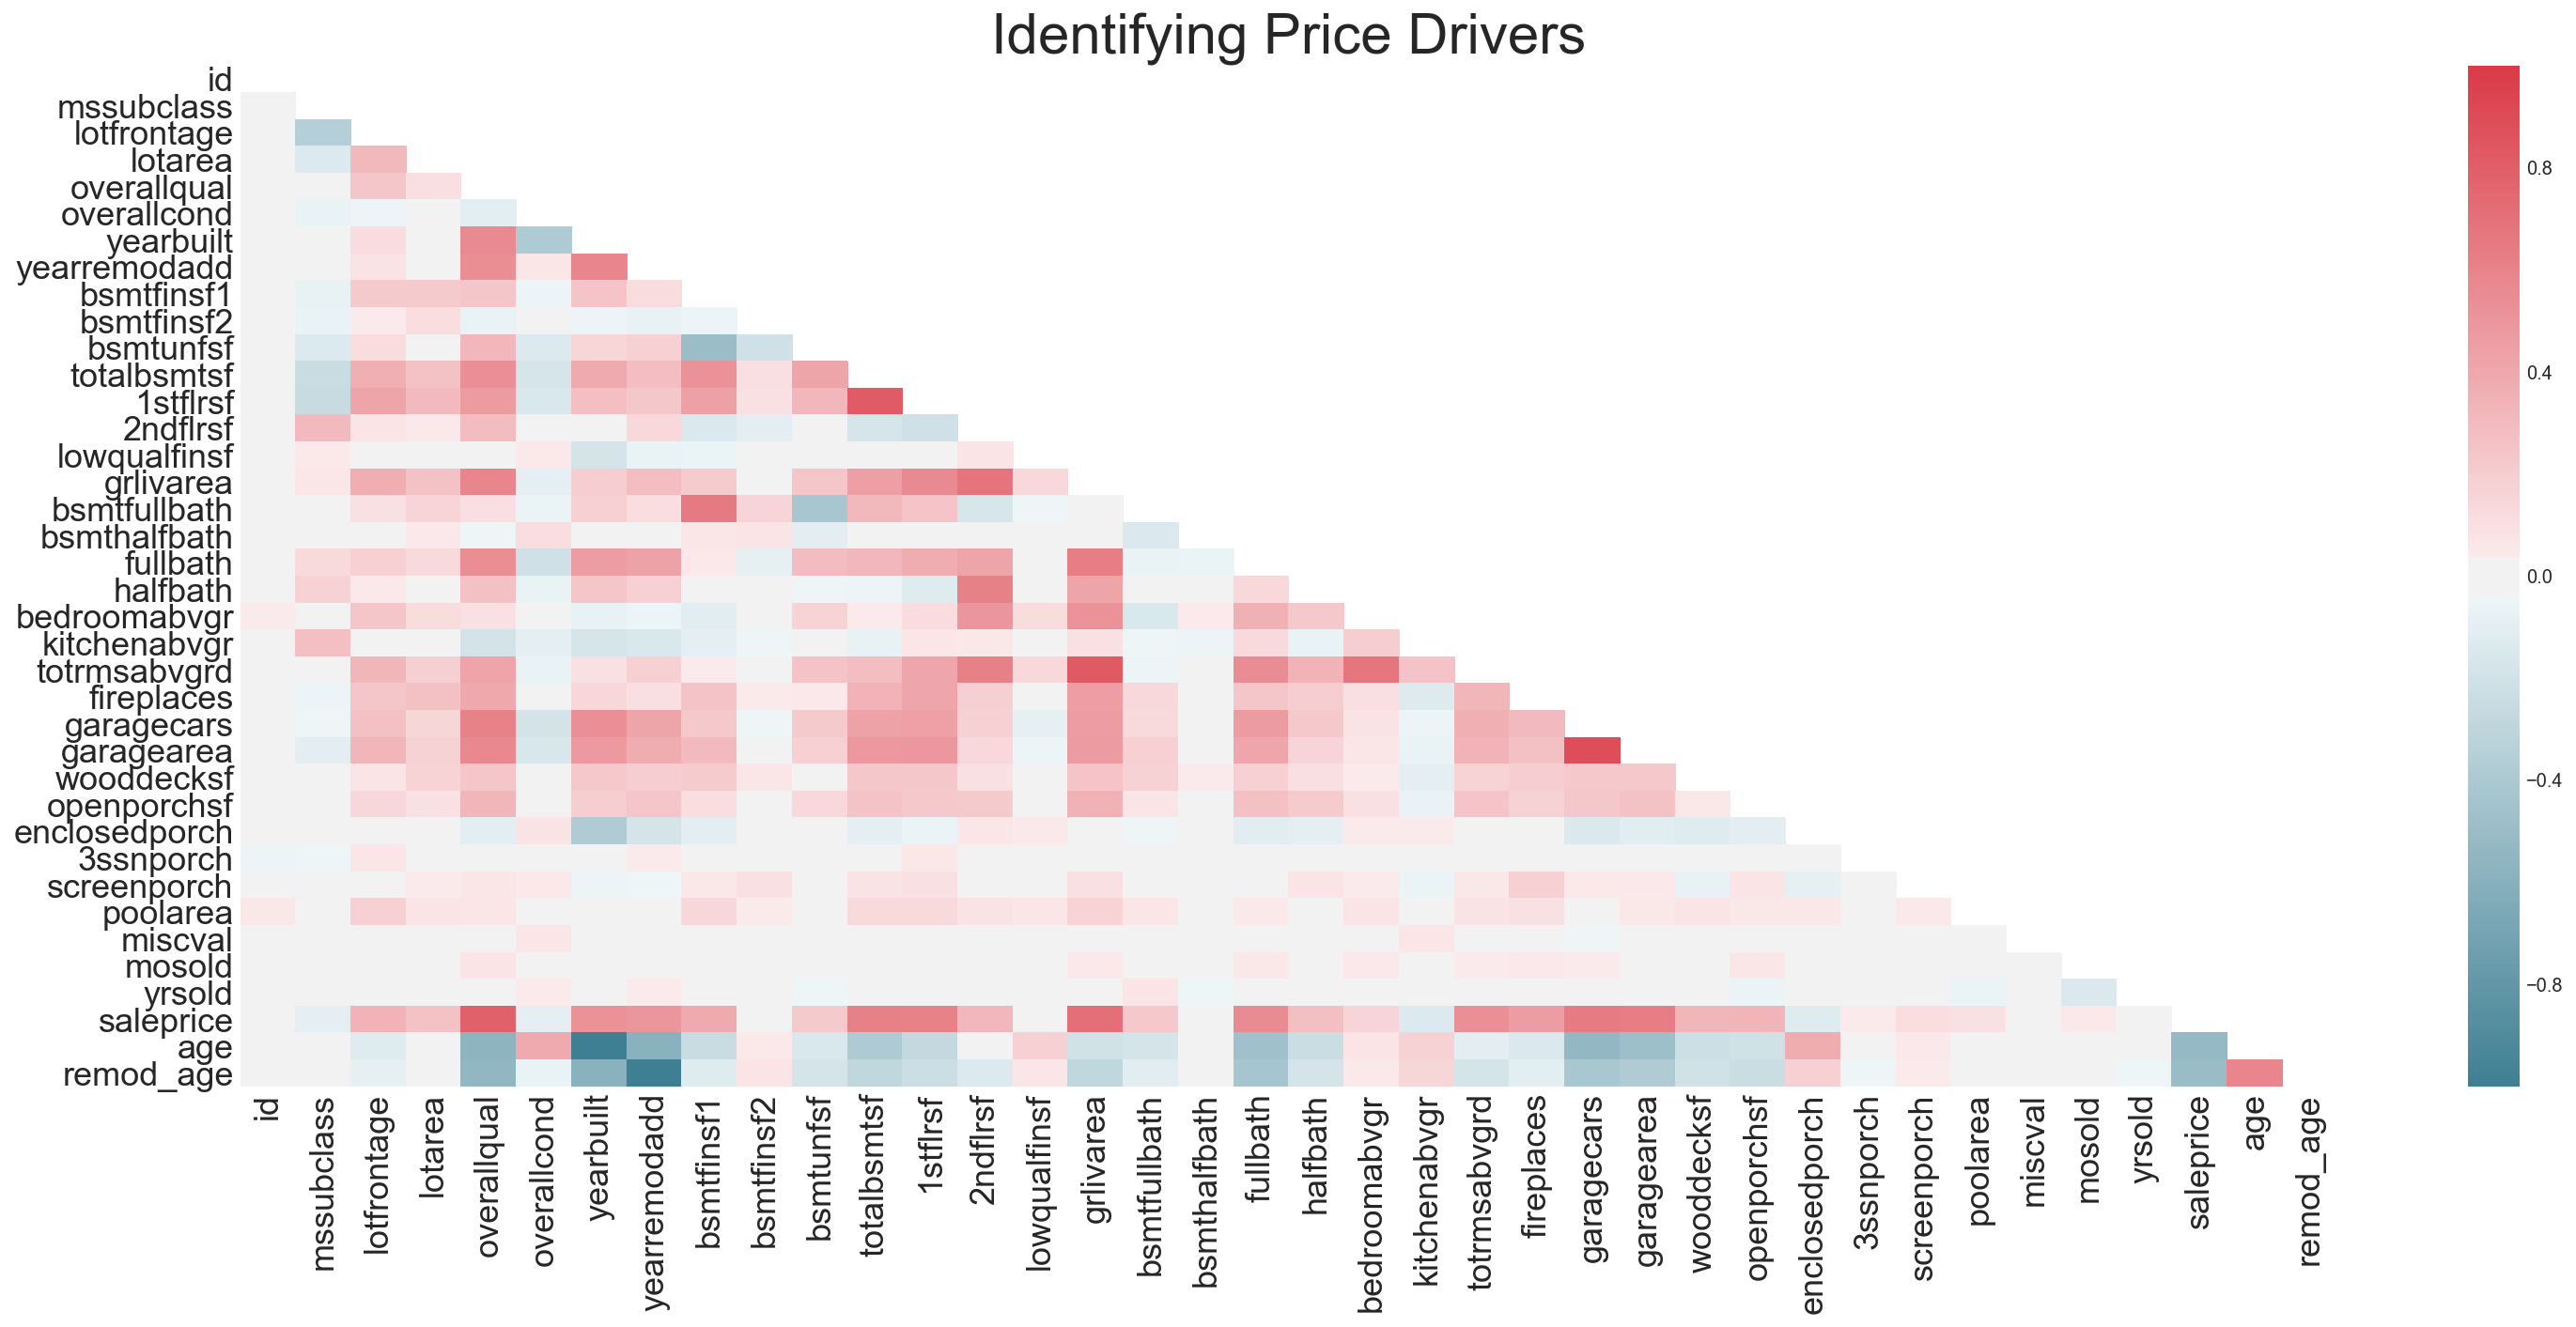

In [3]:
# Identify Price Drivers

fig,ax=plt.subplots(figsize=(25,10))
cmap=sns.diverging_palette(220,10, as_cmap=True)

house_corr=house.corr()
mask=np.zeros_like(house_corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plot_a = sns.heatmap(house_corr, mask = mask, ax=ax, cmap=cmap)
plot_a.tick_params(labelsize = 18)
plot_a.set_title('Identifying Price Drivers', fontsize=30)
plt.show()

## Selecting Fixed Features

|Predictor   |Description   |   
|---|
| lotfrontage  | linear feet of street connected to property  |   
|  lotarea | lot size in sq ft  |   
| lotconfig  | lot config eg Inside Lot, Corner Lot ...  |   
|neighborhood |physical location |
|bldgtype | type of dwelling |
|housestyle |style of dwelling
|bsmtqual | height of basement |
|totalbsmtsf | total sq ft of basement area |
|1stflrsf | |
|2ndflrsf | |
| grlivarea |above grade ground living area sq ft|
|fullbath  | |
|bedroomabvgr | |
| kitchenabvgr | |
| totrmsabvgrd | |
| fireplaces | |
|garagearea | **garagecars** removed, as garagearea and garagecars are highly correlated |
|wooddecksf | |
|openporchsf | |
|enclosedporchsf | |
|poolarea | |
|age |Calculated proxy for yearbuilt |
|remod_age |Calculated proxy for yearremodadd |
| | |



In [4]:
# filter for train dataset
#house = house[(house['yrsold'] != 2010)]
#house['yrsold'].unique()

In [5]:
# drop multiple columns
house_fixed = house
house_fixed.drop(['id','mssubclass', 'mszoning','street','lotshape','landcontour','utilities','landslope','condition1','condition2',
            'overallqual','overallcond','yearbuilt','yearremodadd','roofstyle','roofmatl','exterior1st','exterior2nd',
            'exterqual','extercond','foundation','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfinsf1','bsmtfintype2',
            'bsmtfinsf2','bsmtunfsf','heating','heatingqc','centralair','electrical','lowqualfinsf','bsmtfullbath',
            'bsmthalfbath','halfbath','kitchenqual','functional','fireplacequ', u'garagetype','garagefinish','garagecars',
            'garagequal','garagecond','paveddrive','3ssnporch','screenporch','poolqc','fence','miscfeature','miscval',
            'mosold','saletype','salecondition'],axis=1, inplace=True)


In [6]:
col_fixed = list(house_fixed.columns)
print col_fixed

['lotfrontage', 'lotarea', 'lotconfig', 'neighborhood', 'bldgtype', 'housestyle', 'bsmtqual', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'grlivarea', 'fullbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'poolarea', 'yrsold', 'saleprice', 'age', 'remod_age']


In [7]:
# Understanding the non numeric features that have been selected

print house_fixed['lotconfig'].unique(),'\n'
print house_fixed['neighborhood'].unique(),'\n'
print house_fixed['bldgtype'].unique(),'\n'
print house_fixed['housestyle'].unique(),'\n'
print house_fixed['bsmtqual'].unique()

['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 

['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 

['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 

['Gd' 'TA' 'Ex' 'No' 'Fa']


In [8]:
# map qualitative values to numeric values for bsmtqual
convert = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No':0}
house_fixed['bsmtqual']= house['bsmtqual'].map(convert)


# Create df for the non numeric features
obj_df = house_fixed.select_dtypes(include=['object']).copy()
obj_df.head(4)

,lotconfig,neighborhood,bldgtype,housestyle
0,Inside,CollgCr,1Fam,2Story
1,FR2,Veenker,1Fam,1Story
2,Inside,CollgCr,1Fam,2Story
3,Corner,Crawfor,1Fam,2Story


In [9]:
# binarize the non numeric features
dummy = pd.get_dummies(obj_df, columns=['lotconfig','neighborhood','bldgtype','housestyle'], 
               prefix =['lotconfig','neighbor','bldgtype','housestyle'], drop_first=True)
dummy.head(2)

,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,neighbor_Blueste,neighbor_BrDale,neighbor_BrkSide,neighbor_ClearCr,neighbor_CollgCr,neighbor_Crawfor,neighbor_Edwards,neighbor_Gilbert,neighbor_IDOTRR,neighbor_MeadowV,neighbor_Mitchel,neighbor_NAmes,neighbor_NPkVill,neighbor_NWAmes,neighbor_NoRidge,neighbor_NridgHt,neighbor_OldTown,neighbor_SWISU,neighbor_Sawyer,neighbor_SawyerW,neighbor_Somerst,neighbor_StoneBr,neighbor_Timber,neighbor_Veenker,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl
0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [10]:
house_fixed = pd.concat([house_fixed,dummy],axis=1)
house_fixed.head(2)


,lotfrontage,lotarea,lotconfig,neighborhood,bldgtype,housestyle,bsmtqual,totalbsmtsf,1stflrsf,2ndflrsf,grlivarea,fullbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garagearea,wooddecksf,openporchsf,enclosedporch,poolarea,yrsold,saleprice,age,remod_age,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,neighbor_Blueste,neighbor_BrDale,neighbor_BrkSide,neighbor_ClearCr,neighbor_CollgCr,neighbor_Crawfor,neighbor_Edwards,neighbor_Gilbert,neighbor_IDOTRR,neighbor_MeadowV,neighbor_Mitchel,neighbor_NAmes,neighbor_NPkVill,neighbor_NWAmes,neighbor_NoRidge,neighbor_NridgHt,neighbor_OldTown,neighbor_SWISU,neighbor_Sawyer,neighbor_SawyerW,neighbor_Somerst,neighbor_StoneBr,neighbor_Timber,neighbor_Veenker,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl
0,65.0,8450,Inside,CollgCr,1Fam,2Story,4,856,856,854,1710,2,3,1,8,0,548,0,61,0,0,2008,208500,15,15,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,80.0,9600,FR2,Veenker,1Fam,1Story,4,1262,1262,0,1262,2,3,1,6,1,460,298,0,0,0,2007,181500,42,42,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [11]:
house_fixed.drop(['lotconfig','neighborhood','bldgtype','housestyle'],axis=1, inplace=True)


In [12]:
col_fixed_2 = list(house_fixed.columns)
col_fixed_2.remove('saleprice')
print col_fixed_2

['lotfrontage', 'lotarea', 'bsmtqual', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'grlivarea', 'fullbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'poolarea', 'yrsold', 'age', 'remod_age', 'lotconfig_CulDSac', 'lotconfig_FR2', 'lotconfig_FR3', 'lotconfig_Inside', 'neighbor_Blueste', 'neighbor_BrDale', 'neighbor_BrkSide', 'neighbor_ClearCr', 'neighbor_CollgCr', 'neighbor_Crawfor', 'neighbor_Edwards', 'neighbor_Gilbert', 'neighbor_IDOTRR', 'neighbor_MeadowV', 'neighbor_Mitchel', 'neighbor_NAmes', 'neighbor_NPkVill', 'neighbor_NWAmes', 'neighbor_NoRidge', 'neighbor_NridgHt', 'neighbor_OldTown', 'neighbor_SWISU', 'neighbor_Sawyer', 'neighbor_SawyerW', 'neighbor_Somerst', 'neighbor_StoneBr', 'neighbor_Timber', 'neighbor_Veenker', 'bldgtype_2fmCon', 'bldgtype_Duplex', 'bldgtype_Twnhs', 'bldgtype_TwnhsE', 'housestyle_1.5Unf', 'housestyle_1Story', 'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 'houses

In [13]:
# define test and train sets

house_fixed_train = house_fixed[house_fixed.yrsold != 2010]
house_fixed_test = house_fixed[house_fixed.yrsold == 2010]

In [14]:
X_train = house_fixed_train[col_fixed_2].values
y_train = house_fixed_train['saleprice']

X_test = house_fixed_test[col_fixed_2].values
y_test = house_fixed_test['saleprice']


In [15]:
# standardise the test predictor matrix
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
print Xs_train.std(), Xs_train.mean()

# standardise the train predictor matrix
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs_test = ss.fit_transform(X_test)
print Xs_test.std(), Xs_test.mean()


1.0 2.49555025063e-16
0.929734789959 -4.90126049499e-18


score 0.82359878665 

RMSE_train 33207.1023972


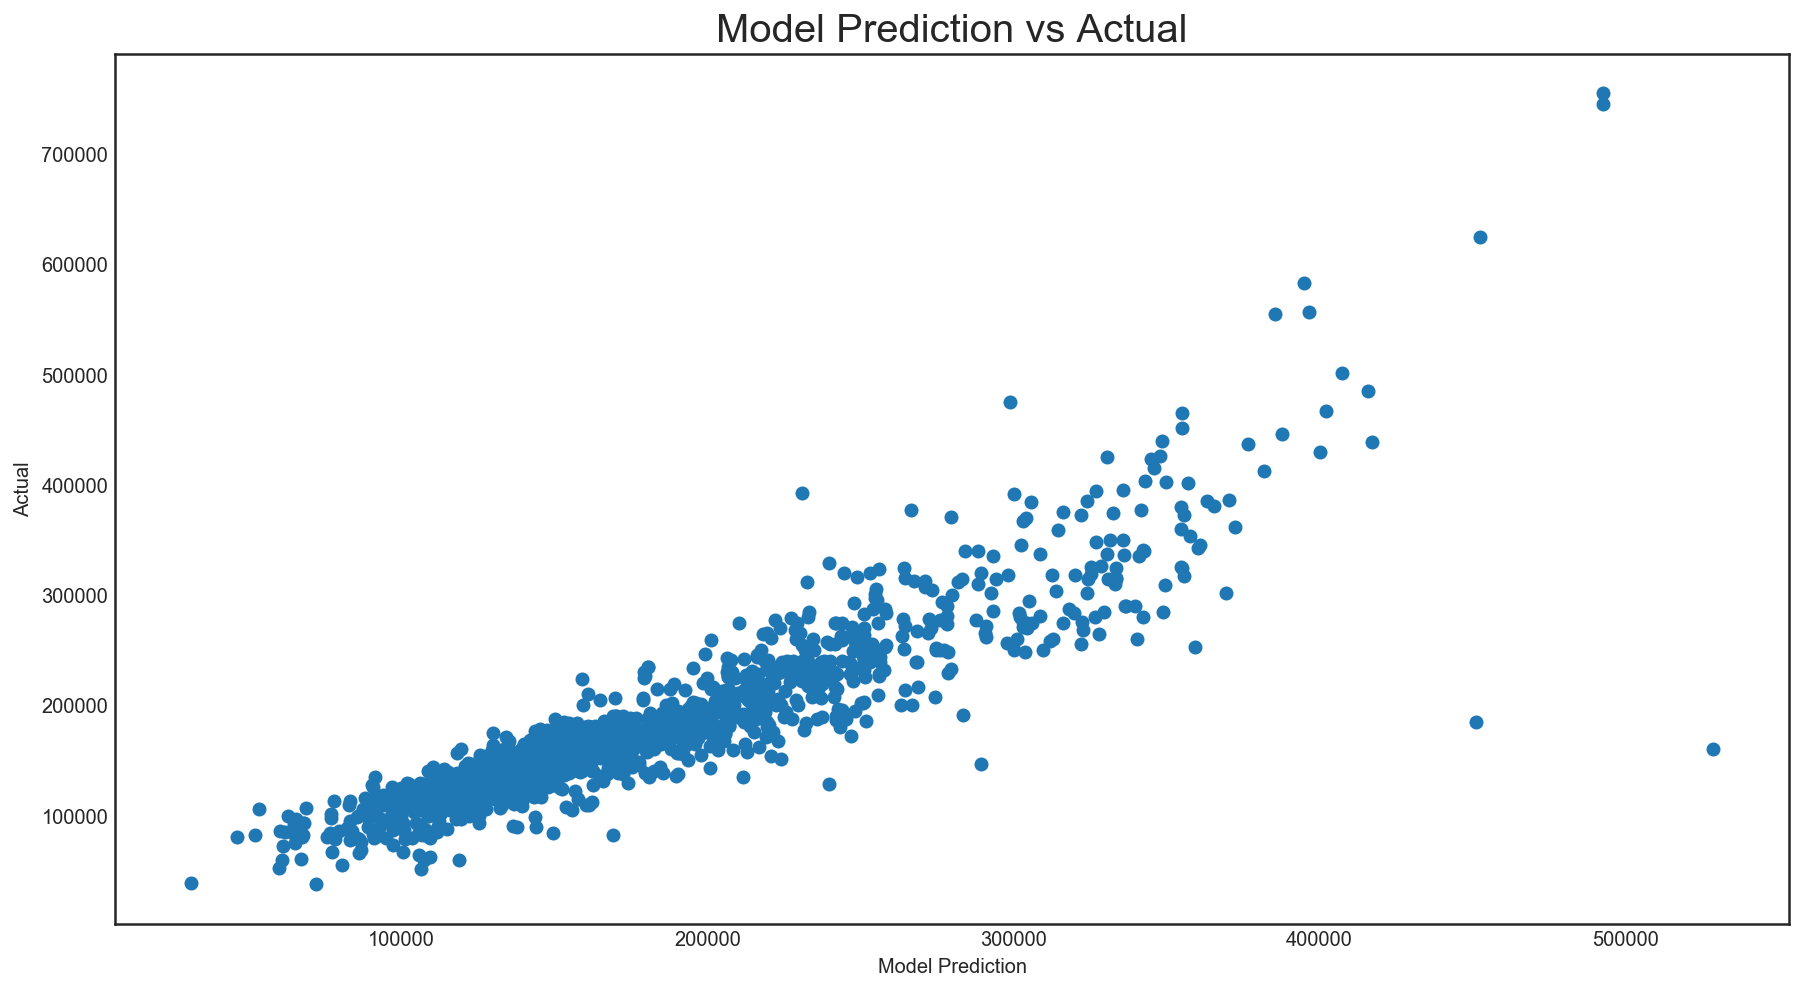

In [16]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

lm = linear_model.LinearRegression()
model = lm.fit(Xs_train,y_train)

model_coef = model.coef_
predict = model.predict(Xs_train)
score = model.score(Xs_train,y_train)
RMSE_train = (mean_squared_error(y_train, predict))**0.5

print 'score', score,'\n'
print 'RMSE_train', RMSE_train

plt.figure(figsize=(15,8))
plt.scatter(predict, y_train)
plt.title('Model Prediction vs Actual', fontsize=20)
plt.xlabel ('Model Prediction')
plt.ylabel ('Actual')
plt.show()

In [17]:
# checking the model drivers

model_coef = pd.DataFrame(zip(col_fixed_2,model.coef_),columns=['feature','coef']).sort_values(by=['coef'])
print 'Top 20 Model Drivers','\n','\n' 
print model_coef.tail(10),'\n'
print model_coef.head(10)

#model_coef.sort_values(by=['coef'])

Top 20 Model Drivers 


              feature          coef
10       totrmsabvgrd   5922.839012
12         garagearea   6640.852661
4            1stflrsf   7090.827599
45   neighbor_StoneBr   8958.390299
2            bsmtqual   9778.404982
53  housestyle_1Story   9874.225156
38   neighbor_NoRidge  10120.990207
5            2ndflrsf  12971.737896
39   neighbor_NridgHt  14342.750956
6           grlivarea  22861.668704 

             feature         coef
51   bldgtype_TwnhsE -8605.554716
18               age -8130.602792
50    bldgtype_Twnhs -7616.679995
19         remod_age -7110.883346
8       bedroomabvgr -6692.027508
9       kitchenabvgr -6528.524257
30  neighbor_Edwards -4514.974442
40  neighbor_OldTown -3915.526239
37   neighbor_NWAmes -3389.365781
31  neighbor_Gilbert -3364.008959


## Price Predictors

* Features that matter are the neighborhood, area, age, remod age 



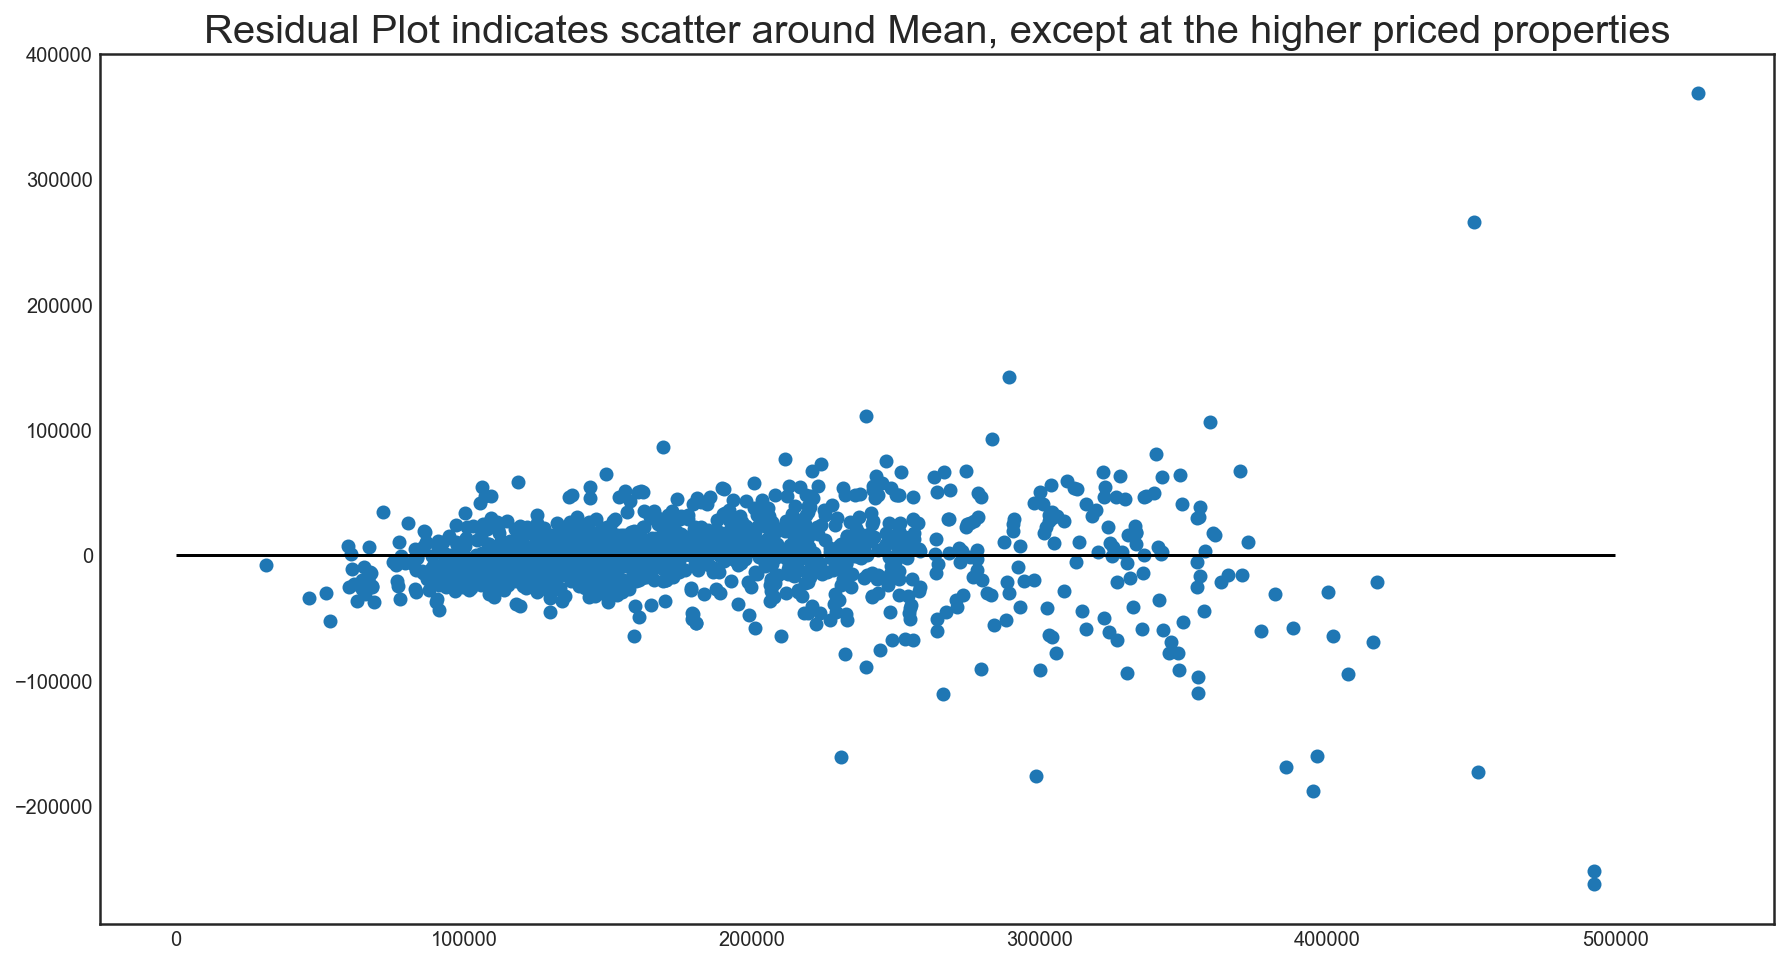

In [18]:
# Residual plot to check model
plt.figure(figsize=(15,8))
plt.title('Residual Plot indicates scatter around Mean, except at the higher priced properties', fontsize=20)
plt.scatter(model.predict(Xs_train),model.predict(Xs_train) - y_train)
plt.hlines(y=0, xmin=0,xmax= 500000)
plt.show()



In [19]:
# test model against 2010 data
#house_fixed_test = house_fixed[house_fixed.yrsold == 2010]

#X_fixed_test = house_fixed_test[col_fixed_2].values
#y_fixed_test = house_fixed_test['saleprice']


In [20]:
y_fixed_test_predict = model.predict(Xs_test)

score_test = model.score(Xs_test,y_test)
RMSE_test = (mean_squared_error(y_test, y_fixed_test_predict))**0.5

print 'score', score_test,'\n'
print 'RMSE_test', RMSE_test

score 0.837940050799 

RMSE_test 32097.9715177


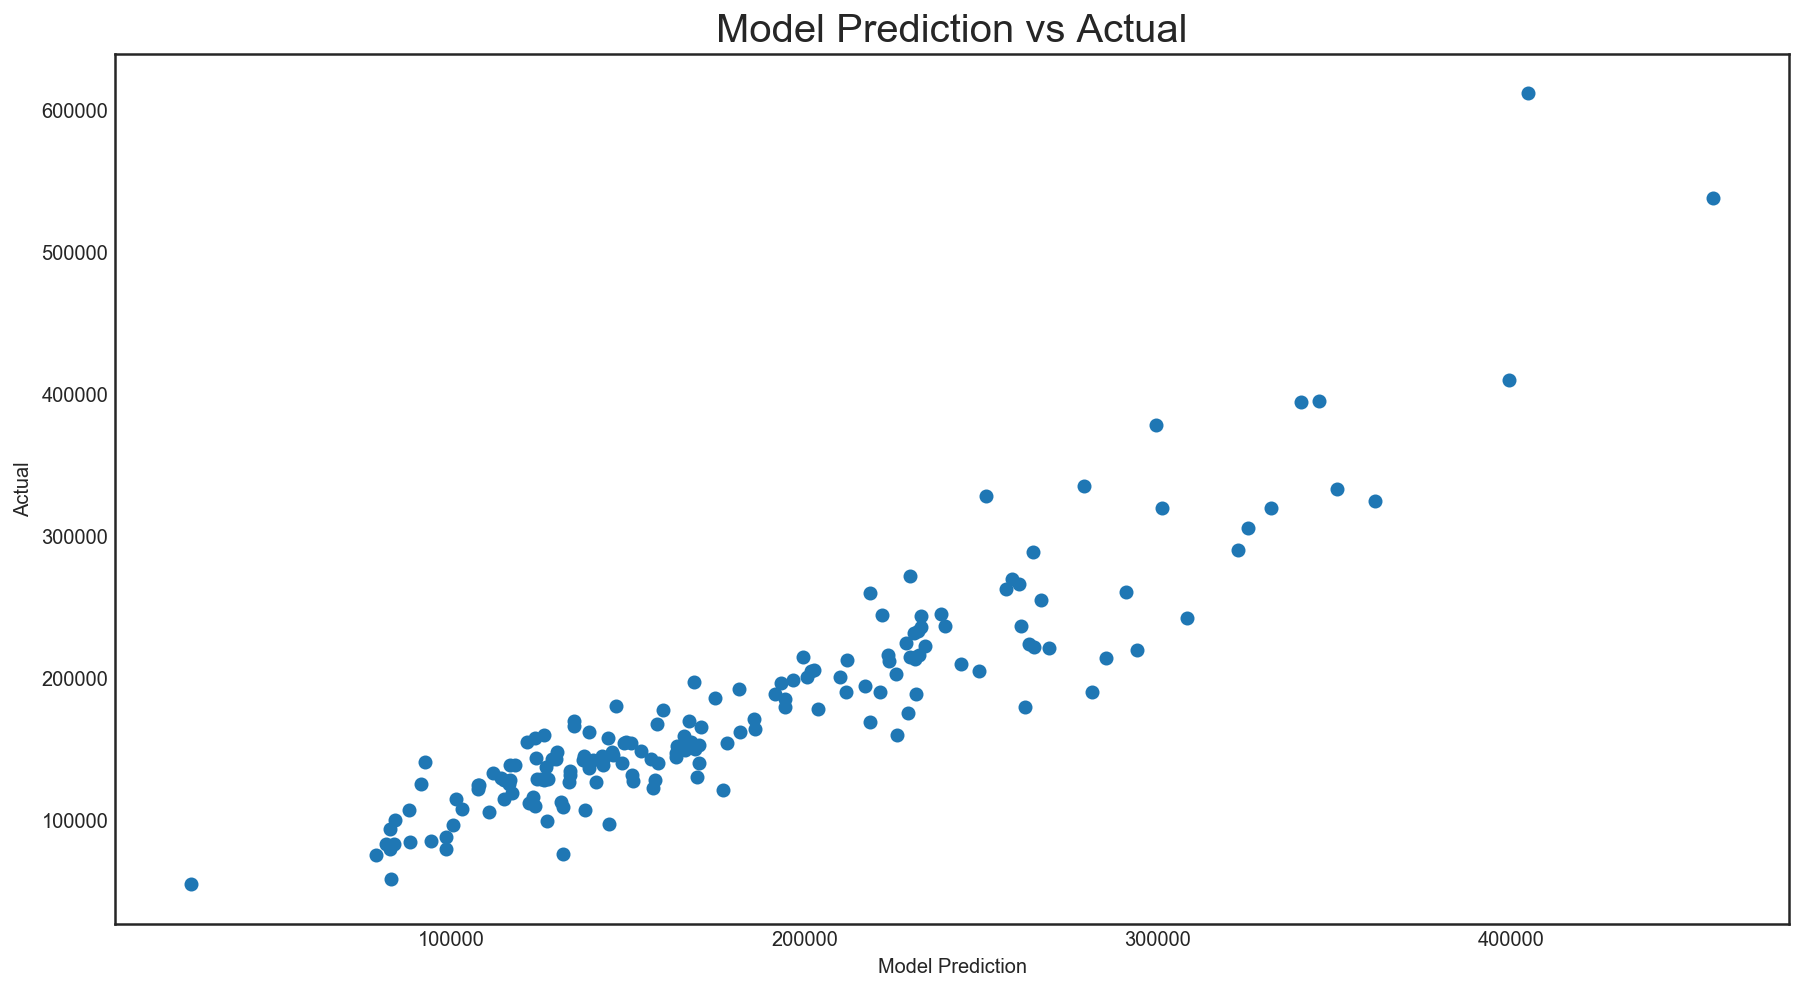

In [21]:
# 2010 data - predicted vs actual
plt.figure(figsize=(15,8))
plt.scatter(y_fixed_test_predict, y_test)
plt.title('Model Prediction vs Actual', fontsize=20)
plt.xlabel ('Model Prediction')
plt.ylabel ('Actual')
plt.show()

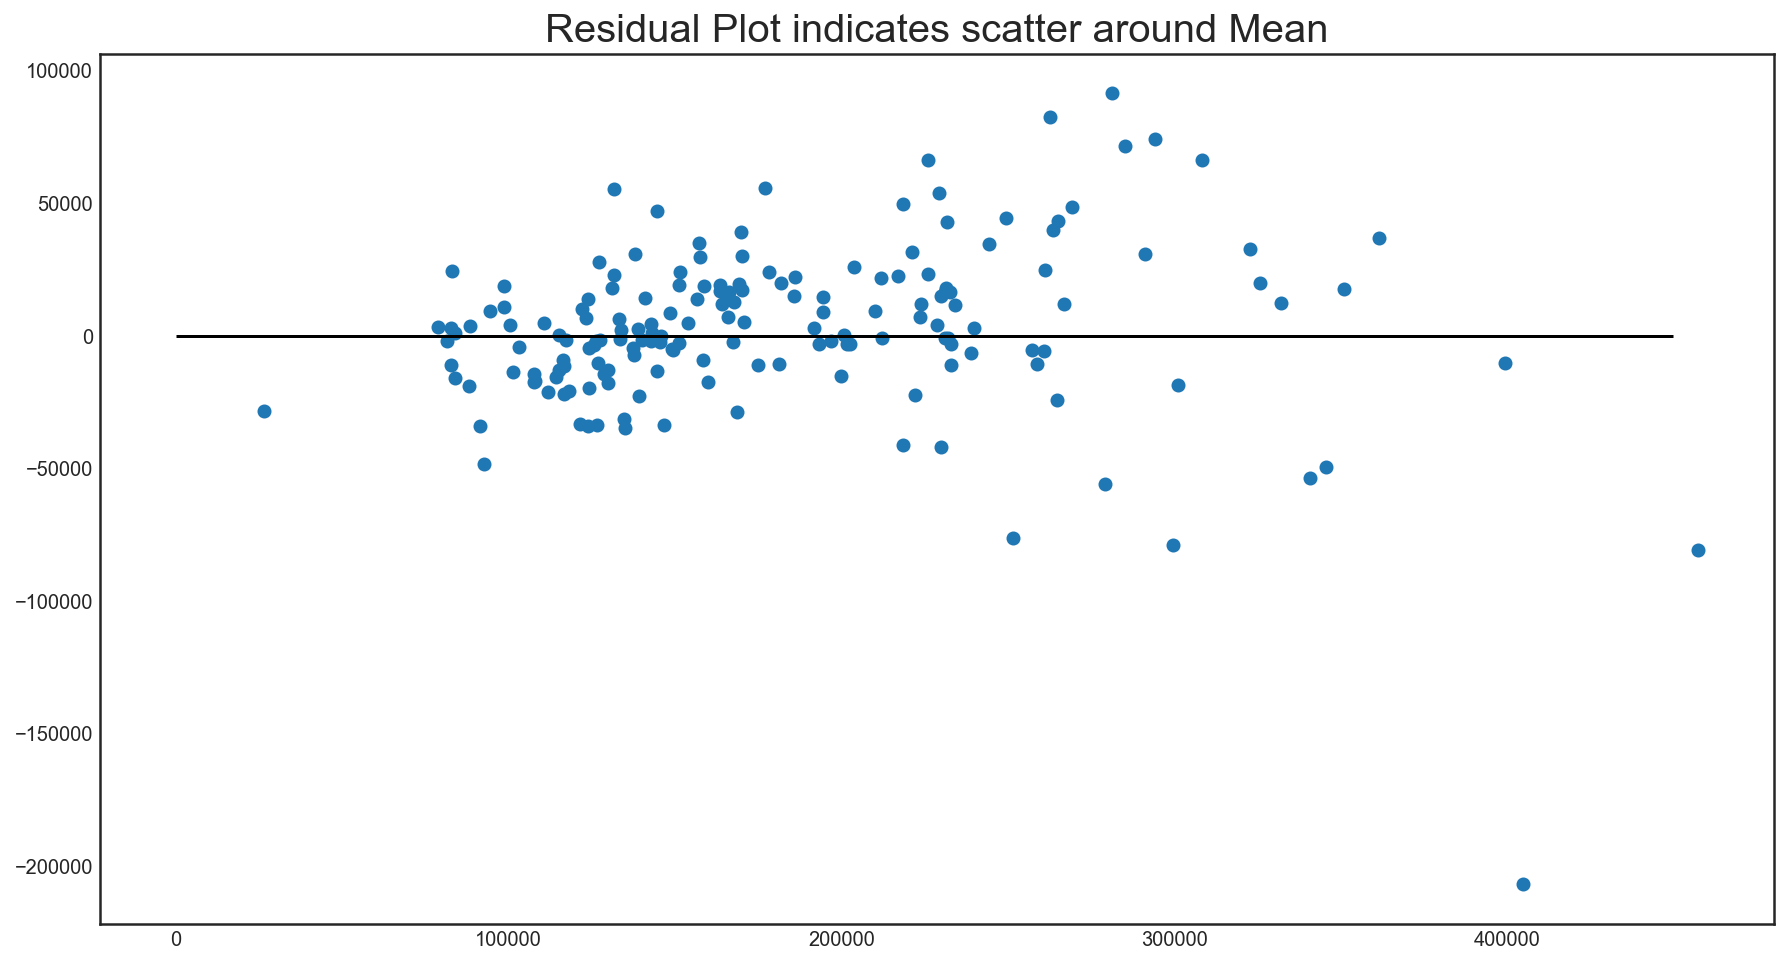

In [22]:
# Residual plot to check model
plt.figure(figsize=(15,8))
plt.title('Residual Plot indicates scatter around Mean', fontsize=20)
plt.scatter(model.predict(Xs_test),model.predict(Xs_test) - y_test)
plt.hlines(y=0, xmin=0,xmax= 450000)
plt.show()

## Commentary

The model looks reasonable with a R squared of **0.82** for the test data and **0.84** for the train data set.
Residual plot indicates that the model is not unusual with the points scattered around the mean.

The Model Prediction vs 2010 Actual does show that the model tends to overweight and as the salesprice increases, the 
accuracy decreases.

The impact of the US Housing crisis should be considered with respect to the model.



![Impact of the US Housing Crisis](https://en.wikipedia.org/wiki/United_States_housing_bubble #/media/File:Median_and_Average_Sales_Prices_of_New_Homes_Sold_in_the_US_1963-2010_Monthly.png) 





In [23]:
import statsmodels.api as sm
y = y_train
X = Xs_train
model2=sm.OLS(y,X).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.108
Date:                Thu, 05 Apr 2018   Prob (F-statistic):           2.16e-13
Time:                        16:43:37   Log-Likelihood:                -17313.
No. Observations:                1278   AIC:                         3.474e+04
Df Residuals:                    1219   BIC:                         3.505e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2530.5248   7403.113     -0.342      0.733   -1.71e+04     1.2e+04
x2          4021.0726   6447.253      0.624      0.533   -8627.869    1.67e+04
x3          9778.4050   9700.696      1.008      0.314   -9253.507    2.88e+04
x4           851.5372   1.29e+04      0.066      0.947   -2.44e+04    2.61e+04
x5          7090.8276   5.89e+04      0.120      0.904   -1.08e+05    1.23e+05
x6          1.297e+04   6.47e+04      0.200      0.841   -1.14e+05     1.4e+05
x7          2.286e+04   7.92e+04      0.288      0.773   -1.33e+05    1.78e+05
x8          3231.0444   8723.732      0.370      0.711   -1.39e+04    2.03e+04
x9         -6692.0275   8608.545     -0.777      0.437   -2.36e+04    1.02e+04
x10        -6528.5243   9275.250     -0.704      0.482   -2.47e+04    1.17e+04
x11         5922.8390   1.24e+04      0.477      0.633   -1.84e+04    3.03e+04
x12         5852.0110   6826.261      0.857      0.391   -7540.512    1.92e+04
x13         6640.8527   7630.905      0.870      0.384   -8330.311    2.16e+04
x14         2656.4205   5909.375      0.450      0.653   -8937.253    1.43e+04
x15         1129.7146   6159.877      0.183      0.855    -1.1e+04    1.32e+04
x16         -184.1150   6084.816     -0.030      0.976   -1.21e+04    1.18e+04
x17           52.7236   5697.866      0.009      0.993   -1.11e+04    1.12e+04
x18         -314.9540   5444.831     -0.058      0.954    -1.1e+04    1.04e+04
x19        -8130.6028   1.37e+04     -0.594      0.553    -3.5e+04    1.87e+04
x20        -7110.8833   7610.450     -0.934      0.350    -2.2e+04    7820.149
x21         2248.3591   6454.727      0.348      0.728   -1.04e+04    1.49e+04
x22        -1757.6290   5921.282     -0.297      0.767   -1.34e+04    9859.405
x23         -608.1368   5445.577     -0.112      0.911   -1.13e+04    1.01e+04
x24          285.5831   6602.640      0.043      0.966   -1.27e+04    1.32e+04
x25           19.3831   5749.960      0.003      0.997   -1.13e+04    1.13e+04
x26         2157.5293   8438.307      0.256      0.798   -1.44e+04    1.87e+04
x27         -163.0435   1.37e+04     -0.012      0.990    -2.7e+04    2.66e+04
x28        -1535.9139   9478.773     -0.162      0.871   -2.01e+04    1.71e+04
x29        -1151.0370   1.76e+04     -0.066      0.948   -3.56e+04    3.33e+04
x30         3628.5546   1.22e+04      0.297      0.767   -2.04e+04    2.76e+04
x31        -4514.9744   1.55e+04     -0.292      0.770   -3.48e+04    2.58e+04
x32        -3364.0090   1.39e+04     -0.241      0.809   -3.07e+04     2.4e+04
x33        -1546.5588   1.01e+04     -0.153      0.878   -2.13e+04    1.82e+04
x34         -533.7912   8006.145     -0.067      0.947   -1.62e+04    1.52e+04
x35        -2737.3637   1.15e+04     -0.239      0.811   -2.52e+04    1.98e+04
x36        -2233.7429   2.11e+04     -0.106      0.916   -4.36e+04    3.91e+04
x3